### This tutorial shows how to get the data into dataloaders from deeplake and makes basic data overview.

To see how to do it with dowloading data and working locally - check make_model tutorial or [last year repo](https://github.com/sinzlab/sensorium/blob/main/notebooks/dataset_tutorial/1_inspect_data.ipynb)

In [ ]:
## TODO - uncomment for colab setup

# !git clone https://github.com/ecker-lab/sensorium_2023
# !pip install git+https://github.com/sinzlab/nnfabrik.git
# !pip install git+https://github.com/sinzlab/neuralpredictors
# !pip install pyarrow
# !pip install wandb
# !pip install GitPython
# !pip install datajoint
# !pip install deeplake
# !pip install parquet
# import sys
# sys.path.append('/content/sensorium_2023')

In [1]:
import deeplake
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from IPython.display import HTML
from matplotlib import animation
import imageio
import os
import numpy as np
import plotly.express as px
from functools import partial

In [2]:
from torchvision.transforms import Compose

In [3]:
# from torchvision.transforms import ToTensor

In [4]:
mice = [
    'dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce',
    'dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce',
    'dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce',
    'dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce',
    'dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce',
]

## Load single dataset and visualise a video

In [5]:
dataset = deeplake.load(f'hub://sinzlab/Sensorium_2023_{mice[0]}_train')
dataset.summary()

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_train



-

hub://sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_train loaded successfully.



Dataset(path='hub://sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_train', tensors=['behavior', 'id', 'pupil_center', 'responses', 'videos'])

    tensor      htype             shape             dtype  compression
   -------     -------           -------           -------  ------- 
   behavior    generic      (360, 3, 262:299)      float32   None   
      id        text            (360, 1)             str     None   
 pupil_center  generic      (360, 2, 262:299)      float32   None   
  responses    generic    (360, 7440, 262:299)     float32   None   
    videos     generic  (360, 4, 262:299, 36, 64)  float32   None   


In [6]:
vid = dataset.videos[0].numpy()

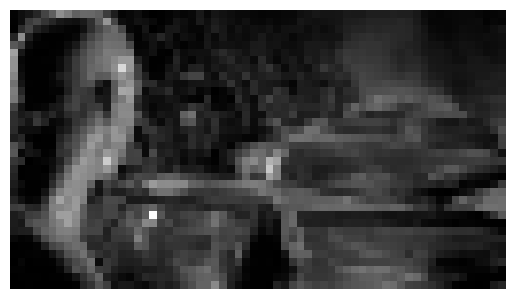

In [7]:
%matplotlib inline
# an equal aspect (square), and turn the axes off
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_axis_off()

# Images are generated and stored in a list to animate later
images_vid = []
images_as_array = []
for image in vid[0,:,:,:]:
    # Scatter plot each point using a dot of size 250 and color red
    #images_vid.append([ax.imshow(image,cmap='gray')])
    images_vid.append([ax.imshow(image, cmap='gray')])
    images_as_array.append(image)
# The animation can now be created using ArtistAnimation
anim = animation.ArtistAnimation(fig,
                                images_vid,
                                interval= 1000 / 30,
                                blit=True,
                                repeat=False
                                )
HTML(anim.to_jshtml())

## Plot reponses and behaviour

In [8]:
responses = dataset.responses[0].numpy()

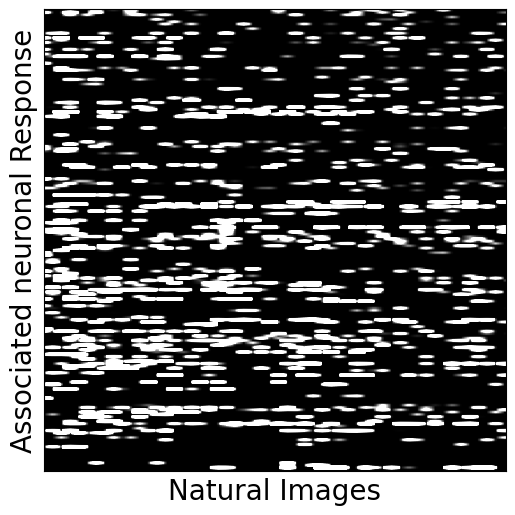

In [9]:
fig,  ax = plt.subplots(1,1, figsize=(6,6))
n_frames = 200
n_neurons = 200
ax.imshow(responses[:n_frames, :n_neurons], cmap="gray",vmin=0, vmax=5)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("Natural Images", fontsize=20, )
ax.set_ylabel("Associated neuronal Response", fontsize=20, );

In [10]:
behaviors = dataset.behavior[0].numpy().T
eye_positions = dataset.pupil_center[0].numpy().T
all_behaviors = np.hstack([np.vstack(behaviors), np.vstack(eye_positions), ])

In [11]:
# all_behaviors.shape

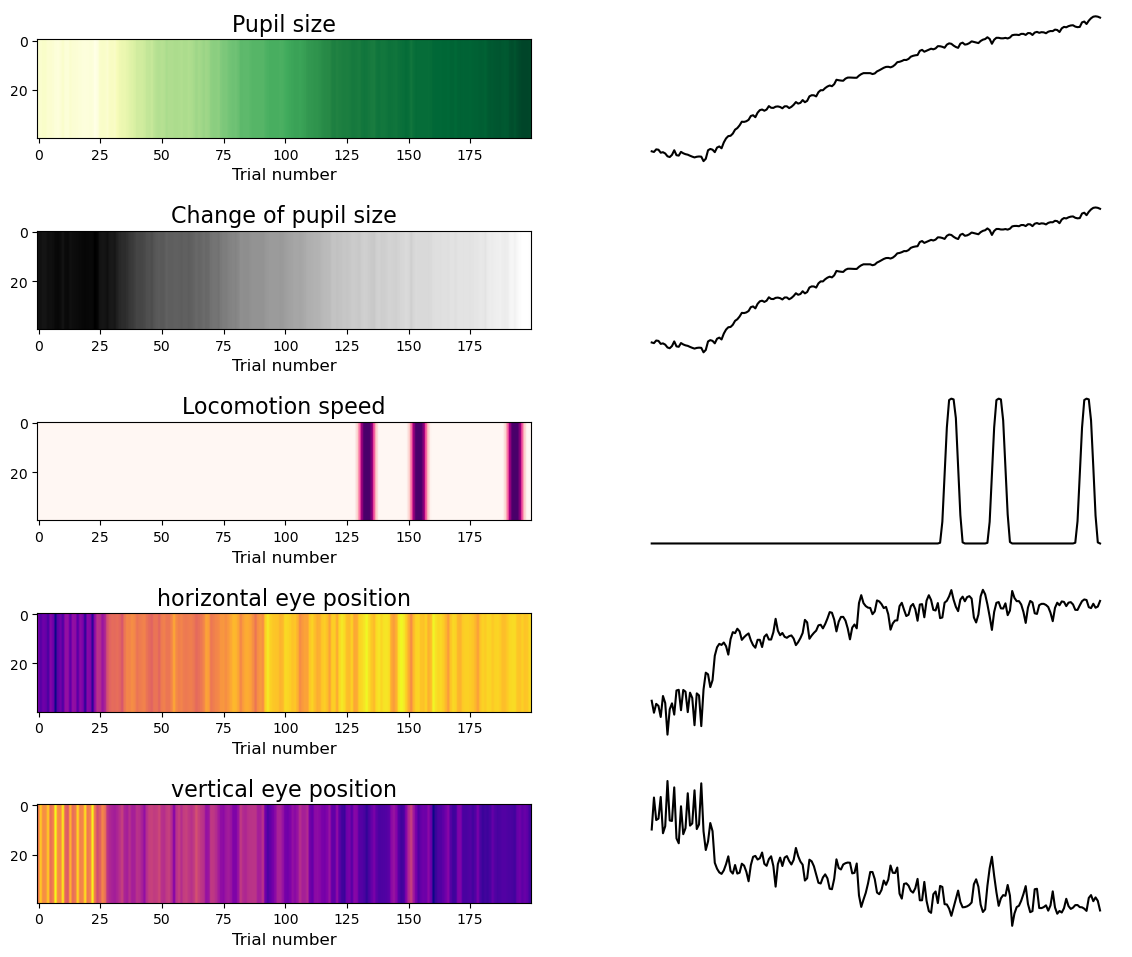

In [12]:
fig, axs = plt.subplots(5,2, figsize=(14,12))

behaviors = ["Pupil size", 
            "Change of pupil size", 
            "Locomotion speed",
            "horizontal eye position",
            "vertical eye position"]
colormaps = ["YlGn", "gray", "RdPu", "plasma", "plasma"]


for i in range(2):
    for behavior in range(5):
        if i == 0:
            axs[behavior, i].imshow(np.tile(all_behaviors[:n_frames, behavior], (40,1)), cmap=colormaps[behavior])
            axs[behavior, i].set_xlabel("Trial number", fontsize=12)
            axs[behavior, i].set_title(behaviors[behavior], fontsize=16)
        else:
            axs[behavior, i].plot(all_behaviors[:n_frames, behavior], 'k-')
            axs[behavior, i].axis("off")

## Get neurons 3D coordinates

In [13]:
cell_motor_coordinates = dataset.info['cell_motor_coordinates']

In [14]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [15]:
c1='#1f77b4' #blue
c2='green' #green
n=n_neurons

colors = []
for x in range(n):
    colors.append(colorFader(c1, c2, x/n))

In [16]:
neuron_subset = cell_motor_coordinates[
    np.random.choice(cell_motor_coordinates.shape[0], 
                     n_neurons, 
                     replace=False)
]

fig = px.scatter_3d(x=neuron_subset[:, 0], 
                    y=neuron_subset[:, 1], 
                    z=neuron_subset[:, 2],
                   color=colors)
fig.show()

## Add augmentations for dataloaders

In [17]:
def neuro_normalise(
    data, dataset_statistic, inputs_mean=None, inputs_std=None, with_responses=True
):
    '''
    adopted from neuropredictors NeuroNormalizer
    https://github.com/sinzlab/neuralpredictors/blob/main/neuralpredictors/data/transforms.py#L309

    - inputs are scaled by the training std of the stats_source and centered on the mean of the movie
    - behavior is divided by the std if the std is greater than 1% of the mean std (to avoid division by 0)
    - eye_position is z-scored
    - reponses are divided by the per neuron std if the std is greater than
            1% of the mean std (to avoid division by 0)

    '''
    data_len = data['videos'].shape[1]
    inputs_mean = inputs_mean if inputs_mean else dataset_statistic['videos']['mean'][:, :, :data_len].transpose(2, 0, 1)
    inputs_std  = inputs_std if inputs_std else dataset_statistic['videos']['std'][:, :, :data_len].transpose(2, 0, 1)
    # -- inputs in deeplake are already stacked with behaviour in different channels, 
    # so we normalise only the first channel
    data['videos'][0, :, :] = (data['videos'][0, :, :] - inputs_mean) / inputs_std
    
    if with_responses:
    
        s = np.array(dataset_statistic['responses']['std'])[:, :data_len]
        threshold = 0.01 * s.mean()
        idx = s > threshold
        response_precision = np.ones_like(s) / threshold
        response_precision[idx] = 1 / s[idx]
        data['responses'] = data['responses'] * response_precision

    eye_mean = np.array(dataset_statistic['pupil_center']['mean'])[:, :data_len]
    eye_std = np.array(dataset_statistic['pupil_center']['std'])[:, :data_len]
    data['pupil_center'] = (data['pupil_center'] - eye_mean) / eye_std
    
    return data

In [18]:
def transform(sample_in, dataset_statistic, frames=150, offset=-1, with_responses=True):
    '''
    As in our dataset videos are not of the same length, 
    to stack them in a batch we are going to subsample 'frames' frames randomly during loading data
    and also normalise things (before subsampling)
    
    NOTE that the amount of frames should be bigger then 50 
    otherwise, the assertion test would fail duringcomputing metric 
    as we delete first 50 frames of responses 
    (and the additional predictions if any)
    '''
    sample_in = neuro_normalise(sample_in, dataset_statistic, with_responses=with_responses)
    
    
    t = sample_in['behavior'].shape[-1]
    if offset < 0:
        i = np.random.randint(0, t - frames)
    
    sample_in['videos'] = sample_in['videos'][:, i : i + frames, :, :]
    sample_in['responses'] = sample_in['responses'][:, i : i + frames]
    sample_in['behavior'] = sample_in['behavior'][:, i : i + frames]
    sample_in['pupil_center'] = sample_in['pupil_center'][:, i : i + frames]
    return sample_in

In [19]:
dataloader = dataset.pytorch(tensors=('videos', 'responses', 
                                      'behavior', 'pupil_center', 'id'), 
                        num_workers=0, 
                        batch_size=16, 
                        transform=partial(transform, dataset_statistic=dataset.info.statistics),
                        shuffle=True)

In [20]:
batch = next(iter(dataloader))

In [21]:
batch['videos'].shape, batch['responses'].shape, batch['behavior'].shape, batch['pupil_center'].shape

(torch.Size([16, 4, 50, 36, 64]),
 torch.Size([16, 7440, 50]),
 torch.Size([16, 3, 50]),
 torch.Size([16, 2, 50]))

In [22]:
batch['id'][:5]

['200', '458', '69', '478', '411']

## Make the dataloaders according to the standard procedure we use for training

In [23]:
dataloaders = {}


for div in ['train', 'val']:
    dataloaders[div] = {}
    for m in mice:
        dataset = deeplake.load(f'hub://sinzlab/Sensorium_2023_{m}_{div}')
        dataloaders[div][m] = dataloader = dataset.pytorch(tensors=('videos', 'responses', 
                                      'behavior', 'pupil_center', 'id'), 
                        num_workers=0, 
                        batch_size=16, 
                        transform=partial(transform, 
                                          dataset_statistic=dataset.info.statistics, 
                                          with_responses=True),
                        shuffle=True)
        
        
for div in ['live_test_main', 'live_test_bonus', 'final_test_main', 'final_test_bonus']:
    dataloaders[div] = {}
    for m in mice:
        dataset = deeplake.load(f'hub://sinzlab/Sensorium_2023_{m}_{div}')
        dataloaders[div][m] = dataloader = dataset.pytorch(tensors=('videos', 
                                      'behavior', 'pupil_center', 'id'), 
                        num_workers=0, 
                        batch_size=16, 
                        transform=partial(neuro_normalise, 
                                          dataset_statistic=dataset.info.statistics,
                                          with_responses=False),
                        shuffle=True)

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_train



/

hub://sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_train loaded successfully.



|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_train



-

hub://sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_train loaded successfully.



\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_train



/

hub://sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_train loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_train



\

hub://sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_train loaded successfully.



|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_train



-

hub://sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_train loaded successfully.



|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_val



/

hub://sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_val loaded successfully.



\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_val



-

hub://sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_val loaded successfully.



|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_val



\

hub://sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_val loaded successfully.



|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_val



|

hub://sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_val loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_val



-

hub://sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_val loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_live_test



/

hub://sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_live_test loaded successfully.



-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_live_test



-

hub://sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_live_test loaded successfully.



-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_live_test



|

hub://sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_live_test loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_live_test



|

hub://sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_live_test loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_live_test



|

hub://sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_live_test loaded successfully.



-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test



-

hub://sinzlab/sensorium2023_dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test loaded successfully.



\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test



/

hub://sinzlab/sensorium2023_dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test loaded successfully.



|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test



/

hub://sinzlab/sensorium2023_dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test



/

hub://sinzlab/sensorium2023_dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test



/

hub://sinzlab/sensorium2023_dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce_fin_test loaded successfully.



In [24]:
dataloaders

{'train': {'dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8bd17a9070>,
  'dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8bdce82910>,
  'dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8bdc13ff10>,
  'dynamic29513-3-5-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8bd1d6d4f0>,
  'dynamic29514-2-9-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8bd3842dc0>},
 'oracle': {'dynamic29156-11-10-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8b6c30a7c0>,
  'dynamic29228-2-10-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8bdc8d2b80>,
  'dynamic29234-6-9-Video-8744edeac3b4d1ce16b680916b5267ce': <torch.utils.data.dataloader.DataLoader at 0x7f8bdcdd1c10>,
  'dyn